# Sample a probability density with Neal's funnel using HMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js

import numpyro
import numpyro.distributions as dist

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig

We model parameters $x$ and $y$. The likelihood is

\begin{equation*}
    p(d|x) \sim \mathcal{N}(\mu=1, \sigma=2)\;.
\end{equation*}

The priors are

\begin{align*}
    &p(x|y) \sim \mathcal{N}(\mu=0, \sigma=e^{y/2}) \\
    &p(y) \sim \mathcal{N}(\mu=0, \sigma=3)\;. \\
\end{align*}

Notice $y$ is a hyper-parameters in that the prior on $x$ is conditioned on $y$ - this is a hierarchical model. By Bayes' theorem, the posterior is

\begin{equation*}
    p(x, y | d) \propto p(d | x)\cdot p(x | y)\cdot p(y)\;.
\end{equation*}

In [2]:
# sample funnel with HMC
def neals_funnel():
    # prior on x and y
    y = numpyro.sample('y', dist.Normal(0.0, 3.0))
    x = numpyro.sample('x', dist.Normal(0.0, jnp.exp(y / 2)))
    # likelihood factor
    numpyro.factor('ln_likelihood', js.stats.norm.logpdf(x, loc=1, scale=2))

nuts_kernel = numpyro.infer.NUTS(neals_funnel)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e5),
                          num_samples=int(1e5))
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()
samples = np.array([samples_dict['x'], samples_dict['y']]).T

sample: 100%|██████████| 200000/200000 [00:24<00:00, 8326.53it/s, 3 steps of size 2.69e-01. acc. prob=0.80] 


In [3]:
# normalize funnel for better sampling
def neals_funnel_normalized():
    # sample from standard normal distribution
    x_normal = numpyro.sample('x_normal', dist.Normal(0.0, 1.0))
    y_normal = numpyro.sample('y_normal', dist.Normal(0.0, 1.0))

    # transform to prior distributions
    y = y_normal * 3.0
    x = x_normal * jnp.exp(y / 2)
    numpyro.deterministic('x', x)
    numpyro.deterministic('y', y)

    # likelihood factor
    numpyro.factor('ln_likelihood', js.stats.norm.logpdf(x, loc=1, scale=2))

nuts_kernel_norm = numpyro.infer.NUTS(neals_funnel_normalized)
mcmc_norm = numpyro.infer.MCMC(sampler=nuts_kernel_norm,
                               num_warmup=int(1e5),
                               num_samples=int(1e5))
mcmc_norm.run(jr.key(1))
samples_dict_norm = mcmc_norm.get_samples()
samples_norm = np.array([samples_dict_norm['x'], samples_dict_norm['y']]).T

sample: 100%|██████████| 200000/200000 [00:24<00:00, 8259.84it/s, 7 steps of size 5.51e-01. acc. prob=0.88]


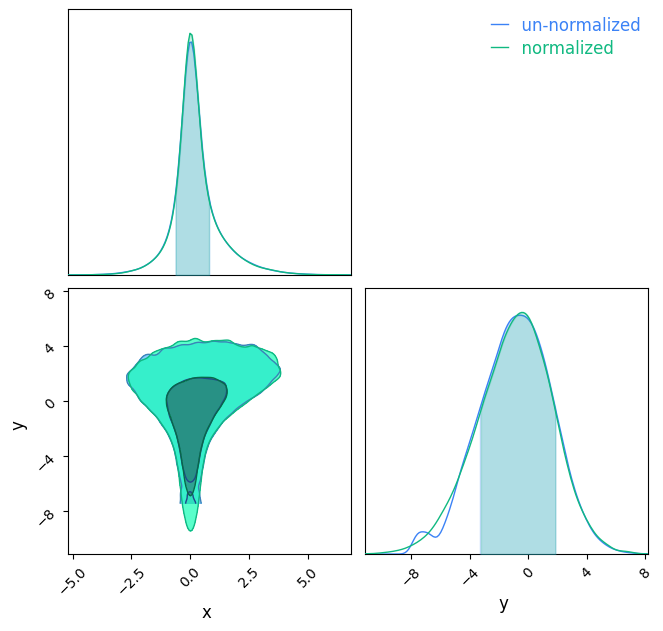

In [4]:
# plot samples of funnel
df = pd.DataFrame(samples, columns=['x', 'y'])
norm_df = pd.DataFrame(samples_norm, columns=['x', 'y'])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='un-normalized'))
c.add_chain(Chain(samples=norm_df, name='normalized'))
fig = c.plotter.plot()

Now we transform our parameters. Instead of sampling over $y$ which leads to a strong funnel, we sample over $|z| = e^{y / 2}$. To account for the change of variable, we multiply the density by the determinant of the Jacobian of the transformation: $dy / dx = 2 / z$.

In [5]:
def neals_funnel_transformed_bad():
    # uniform distribution on z
    z = numpyro.sample('z', dist.Uniform(0, jnp.exp(5.0)))
    # conditional prior on x
    x = numpyro.sample('x', dist.Normal(0.0, z))
    # normal prior on y
    numpyro.factor('lnprior_y', js.stats.norm.logpdf(2 * jnp.log(z), loc=0.0, scale=3.0))
    # determinant of the Jacobian of the transformation
    numpyro.factor('lndet_Jac', -jnp.log(z))
    # likelihood
    numpyro.factor('ln_likelihood', js.stats.norm.logpdf(x, loc=1.0, scale=2.0))

nuts_kernel_transformed = numpyro.infer.NUTS(neals_funnel_transformed_bad)
mcmc_transformed = numpyro.infer.MCMC(sampler=nuts_kernel_transformed,
                                      num_warmup=int(1e5),
                                      num_samples=int(1e5))
mcmc_transformed.run(jr.key(22))
samples_dict_tranformed = mcmc_transformed.get_samples()
# samples over z instead of y
samples_transformed_z_bad = np.array([samples_dict_tranformed['x'],
                                  samples_dict_tranformed['z']]).T
# transform so samples are over y instead of z
samples_transformed_bad = np.array([samples_dict_tranformed['x'],
                                2.0 * jnp.log(jnp.abs(samples_dict_tranformed['z']))]).T

sample: 100%|██████████| 200000/200000 [00:25<00:00, 7945.89it/s, 6 steps of size 3.89e-01. acc. prob=0.70] 


In [6]:
def neals_funnel_transformed():
    # uniform distribution on z
    z = numpyro.sample('z', dist.Uniform(-jnp.exp(5.0), jnp.exp(5.0)))
    # conditional prior on x
    x = numpyro.sample('x', dist.Normal(0.0, jnp.abs(z)))
    # normal prior on y
    numpyro.factor('lnprior_y', js.stats.norm.logpdf(2 * jnp.log(jnp.abs(z)), loc=0.0, scale=3.0))
    # determinant of the Jacobian of the transformation
    numpyro.factor('lndet_Jac', -jnp.log(jnp.abs(z)))
    # likelihood
    numpyro.factor('ln_likelihood', js.stats.norm.logpdf(x, loc=1.0, scale=2.0))

nuts_kernel_transformed = numpyro.infer.NUTS(neals_funnel_transformed)
mcmc_transformed = numpyro.infer.MCMC(sampler=nuts_kernel_transformed,
                                      num_warmup=int(1e5),
                                      num_samples=int(1e5))
mcmc_transformed.run(jr.key(2))
samples_dict_tranformed = mcmc_transformed.get_samples()
# samples over z instead of y
samples_transformed_z = np.array([samples_dict_tranformed['x'],
                                  samples_dict_tranformed['z']]).T
# transform so samples are over y instead of z
samples_transformed = np.array([samples_dict_tranformed['x'],
                                2.0 * jnp.log(jnp.abs(samples_dict_tranformed['z']))]).T

sample: 100%|██████████| 200000/200000 [00:36<00:00, 5549.67it/s, 14 steps of size 3.96e-02. acc. prob=0.80]  


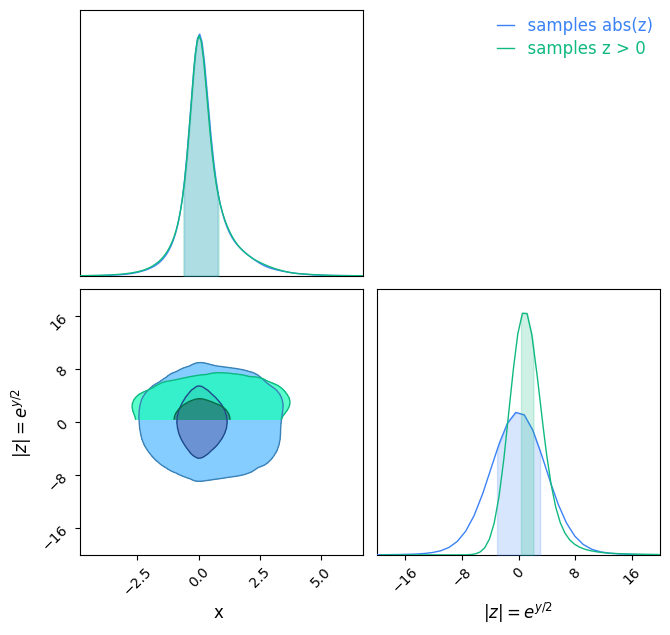

In [7]:
# plot samples over z
transform_df_z = pd.DataFrame(samples_transformed_z, columns=['x', r'$|z| = e^{y/2}$'])
transform_df_z_bad = pd.DataFrame(samples_transformed_z_bad, columns=['x', r'$|z| = e^{y/2}$'])
c = ChainConsumer()
c.set_plot_config(PlotConfig(extents={r'$|z| = e^{y/2}$': (-20, 20)}))
c.add_chain(Chain(samples=transform_df_z, name='samples abs(z)'))
c.add_chain(Chain(samples=transform_df_z_bad, name='samples z > 0'))
fig = c.plotter.plot()

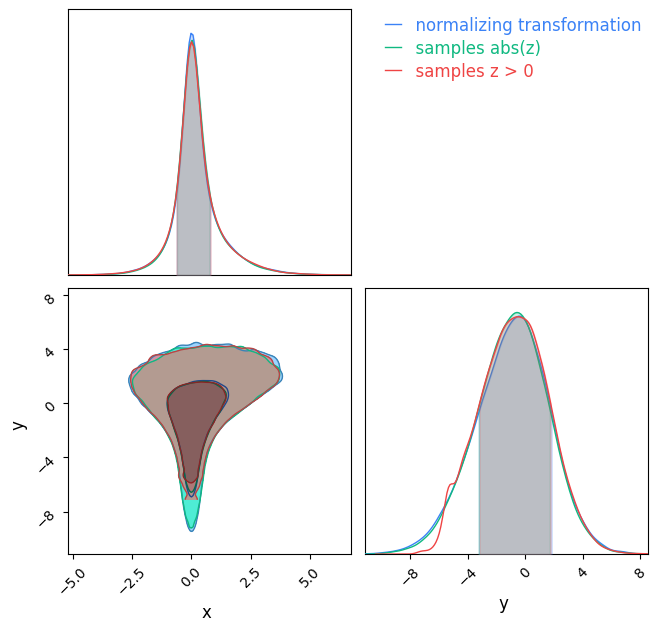

In [8]:
# compare transformed samples to normalized funnel
transform_df = pd.DataFrame(samples_transformed, columns=['x', 'y'])
transform_df_bad = pd.DataFrame(samples_transformed_bad, columns=['x', 'y'])
c = ChainConsumer()
c.add_chain(Chain(samples=norm_df, name='normalizing transformation'))
c.add_chain(Chain(samples=transform_df, name='samples abs(z)'))
c.add_chain(Chain(samples=transform_df_bad, name='samples z > 0'))
fig = c.plotter.plot()

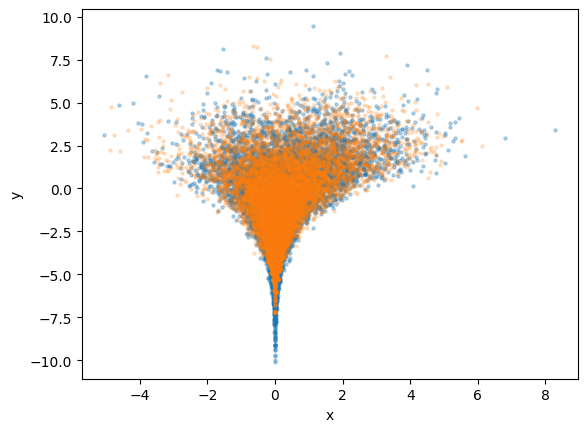

In [9]:
thin = 10
plt.scatter(samples_transformed[::thin, 0], samples_transformed[::thin, 1], color='C0', alpha=0.3, s=5)
plt.scatter(samples_transformed_bad[::thin, 0], samples_transformed_bad[::thin, 1], color='C1', alpha=0.2, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
from flowjax.flows import block_neural_autoregressive_flow
from flowjax.train import fit_to_data
from flowjax.distributions import Normal

flow_key, train_key, sample_key = jr.split(jr.key(0), 3)

x = samples_dict_tranformed['z'][:, None]

flow = block_neural_autoregressive_flow(
    key=flow_key,
    base_dist=Normal(jnp.zeros(x.shape[1])),
)
# flow = triangular_spline_flow(
#     key=flow_key,
#     base_dist=Normal(jnp.zeros(x.shape[1])),
#     flow_layers=4
# )

flow, losses = fit_to_data(
    key=train_key,
    dist=flow,
    x=x,
    learning_rate=5e-3,
    max_epochs=200,
    )

# We can now evaluate the log-probability of arbitrary points
log_probs = flow.log_prob(x)

# And sample the distribution
flow_samples = flow.sample(sample_key, (1000, ))

  6%|▋         | 13/200 [00:13<03:09,  1.01s/it, train=1.87, val=1.87 (Max patience reached)]


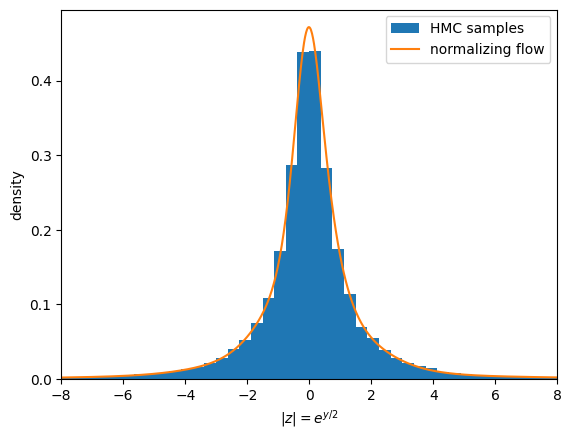

In [11]:
plt.hist(samples_dict_tranformed['z'], bins=500, label='HMC samples', density=True)
z_vals = jnp.linspace(-8, 8, 1000)
plt.plot(z_vals, jnp.exp(flow.log_prob(z_vals[:, None])), label='normalizing flow')
plt.xlim(-8, 8)
plt.legend()
plt.xlabel(r'$|z| = e^{y/2}$')
plt.ylabel('density')
plt.show()

In [12]:
flow.log_prob(jnp.array([1])[:, None])

Array([-1.8044004], dtype=float32)

In [13]:
flow.sample(jr.key(0))

Array([1.1467171], dtype=float32)

In [14]:
def second_sampling_model():
    y = numpyro.sample('y', dist.Uniform(-20., 20.))
    numpyro.factor('kde', flow.log_prob(jnp.array([jnp.exp(y / 2)])[:, None]) + y / 2)

second_nuts_kernel = numpyro.infer.NUTS(second_sampling_model)
second_mcmc = numpyro.infer.MCMC(sampler=second_nuts_kernel,
                                 num_warmup=int(1e4),
                                 num_samples=int(1e5))
second_mcmc.run(jr.key(4))
y_samples = second_mcmc.get_samples()['y']

sample: 100%|██████████| 110000/110000 [00:14<00:00, 7731.56it/s, 3 steps of size 7.38e-01. acc. prob=0.91]


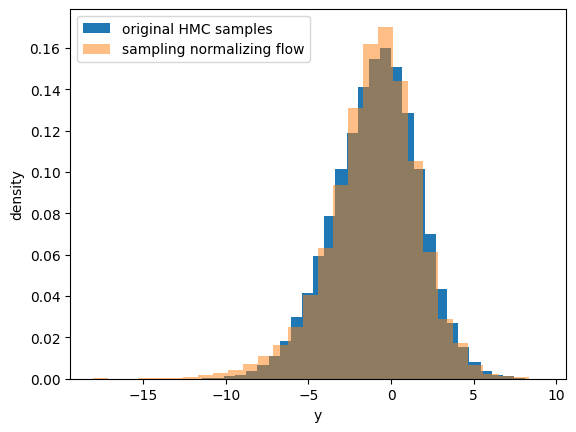

In [15]:
# plt.hist(2 * jnp.log(transform_samples_dict['z']), bins=20, label='HMC samples', density=True)
plt.hist(samples_dict_norm['y'], bins=30, label='original HMC samples', density=True)
plt.hist(y_samples, density=True, bins=30, alpha=0.5, label='sampling normalizing flow')
plt.xlabel('y')
plt.ylabel('density')
plt.legend()
plt.show()